# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

data_dir = '/input/R5KrjnANiKVhLWAkpXhNBe/'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:13<00:00, 4.59KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

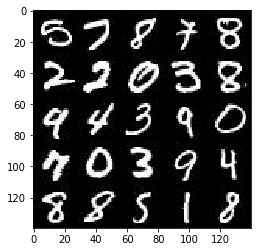

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

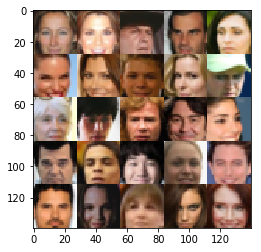

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z = tf.placeholder(tf.float32, shape = (None, z_dim), name ='z')
    lr = tf.placeholder(tf.float32, shape = None, name = 'lr')
    return real_input, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        x = images
        x = tf.layers.conv2d(x,64, 5, strides=2, padding="same")
        x = tf.maximum(alpha* x, x)
        
        x = tf.layers.conv2d(x, 128,5, strides=2, padding="same")
        x = tf.maximum(alpha* x, x)
        
        x = tf.layers.conv2d(x, 256, 4, strides=2, padding="same")
        x = tf.maximum(alpha * x, x)
        
        x = tf.reshape(x, (-1, 4*4*256))
                       
        d_logits = tf.layers.dense(x, 1, activation= None)
        d_output = tf.sigmoid(d_logits)
        return d_output, d_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.1
        
        
        
        z = tf.layers.dense(z, 4*4*512)
        z = tf.reshape(z, (-1,4,4,512))
        z = tf.maximum(alpha*z, z)
        print(z.shape)
        
        z = tf.layers.conv2d_transpose(z,256,4, strides=1, padding='valid')
        z = tf.maximum(alpha*z, z)
        print(z.shape)
        
        z = tf.layers.conv2d_transpose(z,128,4, strides=2, padding='same')
        z = tf.maximum(alpha*z, z)
        print(z.shape)
        
        z = tf.layers.conv2d_transpose(z, out_channel_dim, 4, strides=2, padding="same")
        z = tf.maximum(alpha*z, z)
        print(z.shape)
        
        logits = z
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 5)
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    _, d_logits_real = discriminator(input_real, reuse=False)
    fake = generator(input_z, out_channel_dim, is_train=True)
    d_logits_fake = discriminator(fake, reuse=True)
    #print(input_real)
    #print(input_z)
    #print(d_logits_real.shape)
    #print(d_logits_fake)
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
        # TODO: Implement Function
    # Optimizers
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    inputs_real, z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0 
    

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
            
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
            
            # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

            # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z: batch_images, z: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 1.1865... Generator Loss: 0.8051
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


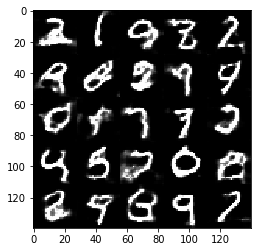

Epoch 2/2... Discriminator Loss: 1.0374... Generator Loss: 1.2470
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


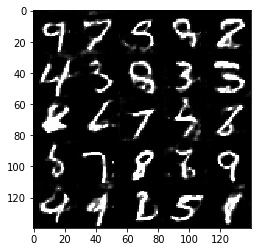

In [15]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.5049
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.7842... Generator Loss: 0.3006
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.6002
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


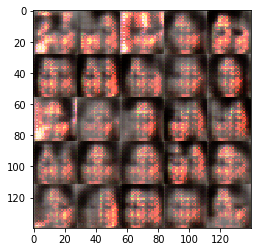

Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 0.4164
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.7207
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


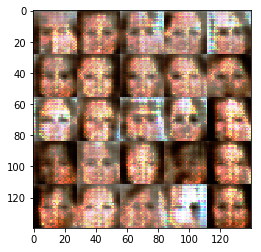

Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.6510... Generator Loss: 0.3488
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.5979
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


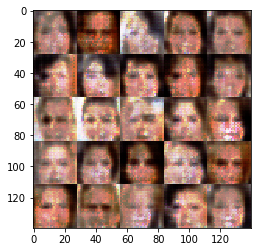

Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7107
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


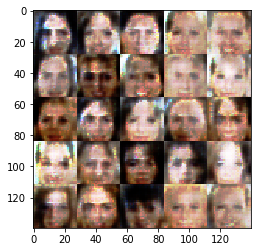

Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.4258
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.4885
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


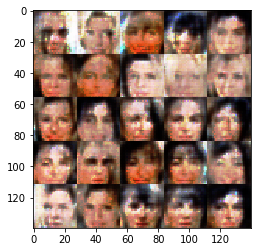

Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.5109
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.6497... Generator Loss: 0.3408
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


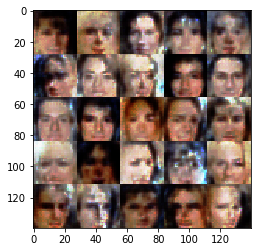

Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 0.3838
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.5308... Generator Loss: 0.3943
Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.6360... Generator Loss: 0.3408
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.5757
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


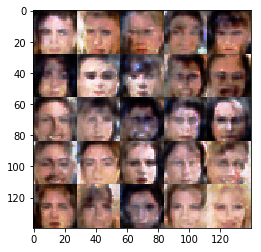

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.6127... Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.4465
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.6964... Generator Loss: 0.3249
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8460
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


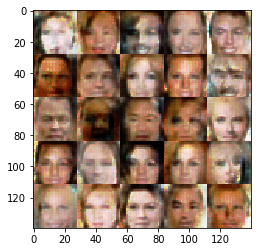

Epoch 1/1... Discriminator Loss: 1.6861... Generator Loss: 0.3343
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.6916
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


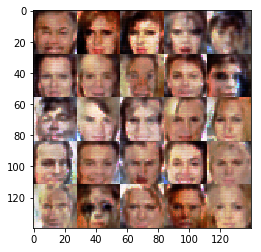

Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.5395
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.5263
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6044
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


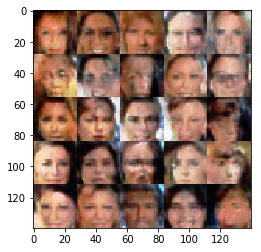

Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.4741
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.5442
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.5715
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.8036
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


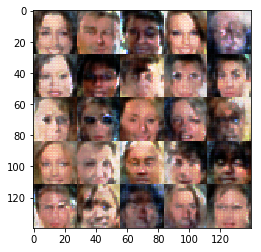

Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.5641... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.4581
Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.3681
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


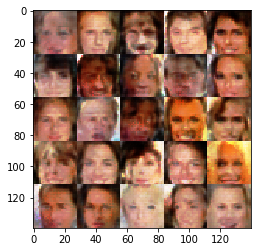

Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.4940
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.4990
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.5703
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


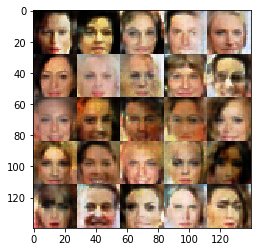

Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.8811... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6837
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


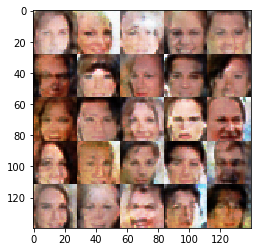

Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.8411
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


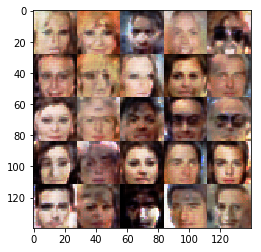

Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.4538
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.8883
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.6312
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


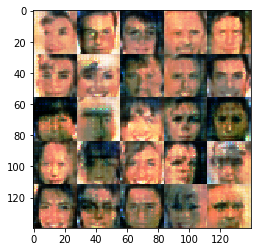

Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.7521... Generator Loss: 0.3282
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.5887
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


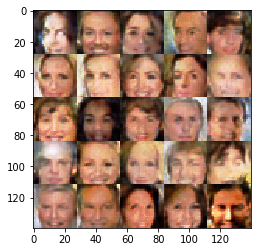

Epoch 1/1... Discriminator Loss: 1.5942... Generator Loss: 0.3678
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.5572
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.5335
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


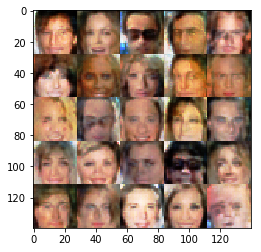

Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 0.3540
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.4624
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.5458
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


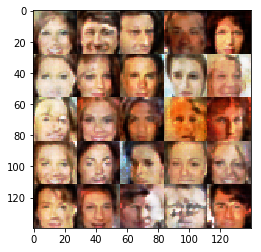

Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.5431
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.4197
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.7794
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


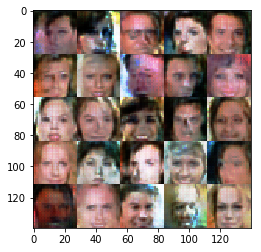

Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.6117


In [17]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.